In [7]:
import os
file_name = r"Kuhne.xlsx"
print(os.path.exists(file_name))

True


In [27]:
import xarray as xr
import pickle as pk
import matplotlib as plt
import os
import cartopy as cp
import geopandas as gp
import sys 
import numpy as np
import pandas as pd
import scipy as sp
import regionmask as rg
import textwrap as tp

In [28]:
def pre_processing_carbon_bombs(excel_file, pickle_file="ds_carbon_bombs.pkl"):
    # (a) Read Excel sheet
    df = pd.read_excel(excel_file, sheet_name="Full Carbon Bombs List")

    # (b) Retain only useful columns
    cols = ["New", "Name", "Country", "Potential emissions (Gt CO2)", "Fuel"]
    df = df[cols].copy()

    # (c) Convert potential emissions to float
    df["Potential emissions (Gt CO2)"] = pd.to_numeric(
        df["Potential emissions (Gt CO2)"], errors="coerce"
    )

    # (d) Create new column "new" (1 if "*" else 0)
    df["new"] = df["New"].apply(lambda x: 1 if str(x).strip() == "*" else 0)

    # (e) Set project name as index
    df = df.set_index("Name")

    # (f) Construct xarray dataset
    ds = xr.Dataset(
        {
            "potential_emissions": (
                ["name"],
                df["Potential emissions (Gt CO2)"].values,
                {"units": "Gt CO2", "description": "Potential emissions per project"},
            ),
            "new": (
                ["name"],
                df["new"].values,
                {"units": "binary", "description": "1 if new carbon bomb, else 0"},
            ),
            "total": (
                [],
                df["Potential emissions (Gt CO2)"].sum(),
                {"units": "Gt CO2", "description": "Total potential emissions"},
            ),
            "total_oil_and_gas": (
                [],
                df.loc[df["Fuel"].str.lower().isin(["oil", "gas"]),
                       "Potential emissions (Gt CO2)"].sum(),
                {"units": "Gt CO2", "description": "Total emissions from oil and gas"},
            ),
            "total_coal": (
                [],
                df.loc[df["Fuel"].str.lower() == "coal",
                       "Potential emissions (Gt CO2)"].sum(),
                {"units": "Gt CO2", "description": "Total emissions from coal"},
            ),
            "total_new_carbon_bombs": (
                [],
                df.loc[df["new"] == 1,
                       "Potential emissions (Gt CO2)"].sum(),
                {"units": "Gt CO2", "description": "Total emissions from new carbon bombs"},
            ),
        },
        coords={
            "name": df.index.values,
            "country": ("name", df["Country"].values),
            "fuel": ("name", df["Fuel"].values),
        },
        attrs={
            "title": "Carbon Bombs Dataset",
            "source": file_name,
            "description": "Dataset of carbon bomb projects with emissions and metadata",
        },
    )

    # Save dataset in pickle format
    with open(pickle_file, "wb") as f:
        pk.dump(ds, f)

    return ds

In [20]:
print(ds)


<xarray.Dataset> Size: 17kB
Dimensions:                 (name: 429)
Coordinates:
  * name                    (name) object 3kB 'Tannezuft Shale' ... nan
    country                 (name) object 3kB 'Algeria' 'Algeria' ... nan nan
    fuel                    (name) object 3kB 'Oil&Gas' 'Oil&Gas' ... 230 169
Data variables:
    potential_emissions     (name) float64 3kB 2.348 2.272 1.216 ... 536.2 419.0
    new                     (name) int64 3kB 1 0 0 0 0 1 0 0 ... 1 0 1 0 0 0 0 0
    total                   float64 8B 3.966e+03
    total_oil_and_gas       float64 8B 0.0
    total_coal              float64 8B 536.2
    total_new_carbon_bombs  float64 8B 382.9
Attributes:
    title:        Carbon Bombs Dataset
    source:       Kuhne.xlsx
    description:  Dataset of carbon bomb projects with emissions and metadata


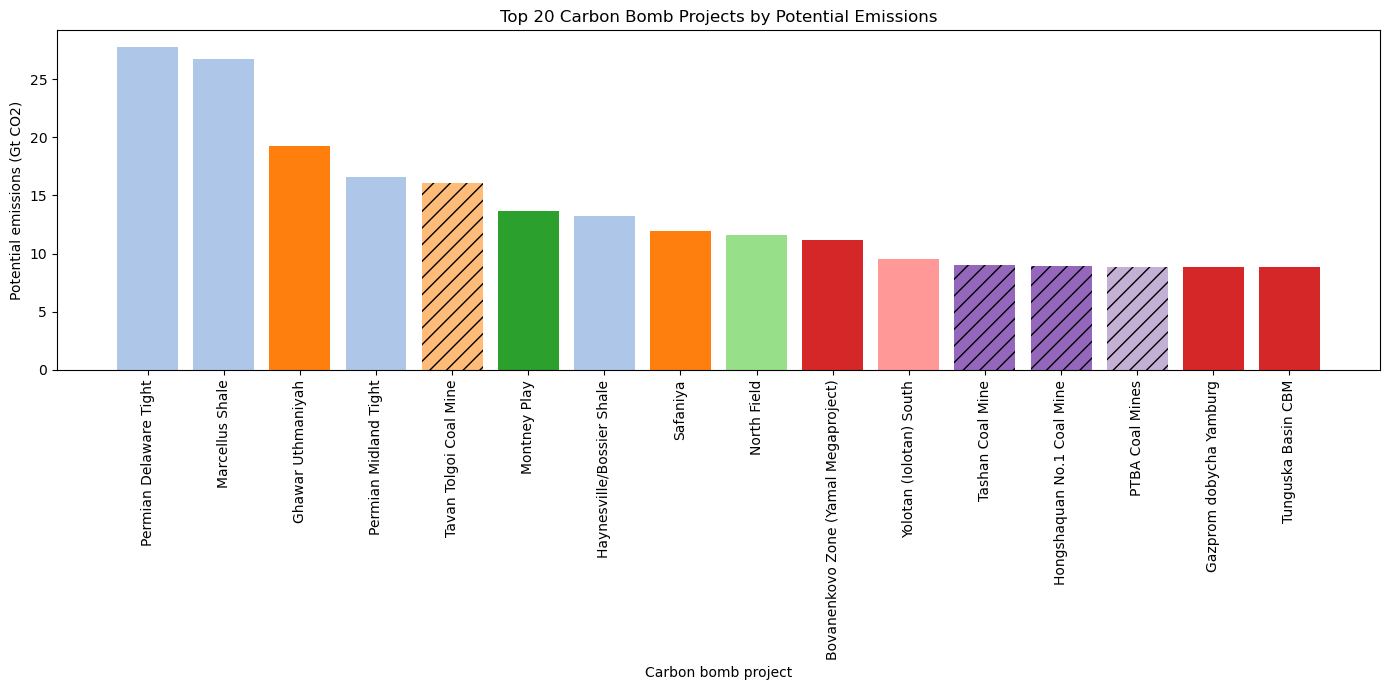

In [33]:
import matplotlib.pyplot as pyplt
# Convert xarray dataset to pandas DataFrame
emissions = ds["potential_emissions"].to_pandas()
countries = ds["country"].to_pandas()
fuels = ds["fuel"].to_pandas()

plot_df = pd.DataFrame({
    "emissions": emissions,
    "country": countries,
    "fuel": fuels
})

# Select top 20 projects by emissions
plot_df = plot_df.sort_values("emissions", ascending=False).head(20)

# Assign colors by country
unique_countries = plot_df["country"].unique()
color_map = {c: plt.cm.tab20(i % 20) for i, c in enumerate(unique_countries)}
colors = plot_df["country"].map(color_map)

# Assign hatches by fuel type
hatch_map = {"coal": "//", "oil": "..", "gas": "xx"}
hatches = plot_df["fuel"].str.lower().map(lambda f: hatch_map.get(f, ""))

# Plot bar chart
fig, ax = pyplt.subplots(figsize=(14, 7))
bars = []
for i, (name, row) in enumerate(plot_df.iterrows()):
    bar = ax.bar(name, row["emissions"], color=colors.iloc[i], hatch=hatches.iloc[i])
    bars.append(bar)

# Labels and formatting
ax.set_ylabel("Potential emissions (Gt CO2)")
ax.set_xlabel("Carbon bomb project")
ax.set_title("Top 20 Carbon Bomb Projects by Potential Emissions")
pyplt.xticks(rotation=90)
pyplt.tight_layout()
pyplt.show()